# Spot-checking inicial: Árvore de Decisão

As árvores de decisão são conhecidas por possuírem um baixo viés, ao mesmo tempo em que apresentam alta variância.
Isto é, o método é capaz de modelar fronteiras de decisão bastante complexas, o que, por um lado, é positivo, mas torna o algoritmo bastante suscetível a ruído ou a padrões nos dados de treino que não generalizam para instâncias de teste.
Por isso, técnicas de poda são fundamentais para o uso efetivo do modelo em dados novos.

Nessa atividade, iremos analisar como a estrutura e as predições da árvore de decisão são afetadas por pequenas variações no conjunto de treino. Além disso, veremos duas técnicas de poda que podem ser usadas para controlar a complexidade do modelo.

## Carregamento dos Dados e Preparação do Ambiente

### Instalação de Pacotes

In [ ]:
! pip install pandas numpy matplotlib scikit-learn imbalanced-learn

### Importação de Bibliotecas
Na célula seguinte são importadas bibliotecas e métodos que serão utilizadas repetidamente ao longo da análise.

In [54]:
from collections import Counter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    classification_report, f1_score,
    ConfusionMatrixDisplay
)

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

### Definição de Constantes Auxiliares
Na célula seguinte são definidas constantes utilitárias diversas que serão usadas ao longo da análise.

In [55]:
random_state = 42

max_depths = [5, 8, 10, 15, 20, 30, 50, None]

configs_to_test = [
    {
        "max_depth": max_depth, 
        "criterion": "gini",
        "random_state": random_state, 
        "class_weight": "balanced"
    }
    for max_depth in max_depths
]

test_ratio = 0.15

train_ratio_holdout = 0.70
valid_ratio_holdout = 0.15

### Obtenção e análise dos dados
O código abaixo carrega o dataset utilizando as funções do scikit-learn e mostra algumas informações básicas sobre os dados

In [56]:
df_sinan_processed = pd.read_csv("../data/3_gold/processed-dataset-numeric.csv")

X = df_sinan_processed.drop("severity", axis=1)
y = df_sinan_processed["severity"]

feature_names = X.columns.tolist()
target_names = ["low_risk", "alarm", "severe"]

y = y.map({name: idx for idx, name in enumerate(target_names)})

In [57]:
# Contagem do número de exemplos em cada classe
class_counts = Counter(y)
for target_class, count in class_counts.items():
    print(f"Número de exemplos na classe '{target_class}' ({target_names[target_class]}): {count}")

Número de exemplos na classe '0' (low_risk): 420850
Número de exemplos na classe '2' (severe): 28523
Número de exemplos na classe '1' (alarm): 267544


### Separação do Conjunto de Teste
Essa separação é realizada independentemente do algoritmo utilizado para particionar os dados entre treino e validação (holdout ou LOOCV).

In [58]:
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=test_ratio, random_state=random_state, stratify=y)

### Particionamento dos Dados (Holdout)

In [7]:
# Fazendo a segunda divisão, para gerar o conjunto de treino e validação
final_test_size = valid_ratio_holdout / (train_ratio_holdout + test_ratio)
X_train, X_valid, y_train, y_valid = train_test_split(X_temp, y_temp, test_size=final_test_size, random_state=random_state, stratify=y_temp)

print(f"Conjuntos gerados com as seguintes proporções: ")
print(f"  Treinamento: {X_train.shape}")
print(f"  Validação: {X_valid.shape}")
print(f"  Teste: {X_test.shape}")

Conjuntos gerados com as seguintes proporções: 
  Treinamento: (501841, 42)
  Validação: (107538, 42)
  Teste: (107538, 42)


## Variância nas Árvores de Decisão


### Analisando a Estrutura das Árvores de Decisão


Como estudado em aula, a árvore de decisão é conhecida por ser um classificador com alta variância. Isso possui consequências na estrutura das árvores treinadas.

O código abaixo treina várias árvores de decisão com diferentes conjuntos de treino obtidos através do método holdout.


In [9]:
def get_root_node(dt, feature_names):
    feature_idx = dt.tree_.feature[0]
    return feature_names[feature_idx]

n_repeats = 5

# Variando o seed do holdout, geramos diferentes conjuntos de treino/teste
for split_random_state in range(0, n_repeats):
  # Holdout com 20% de teste
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=split_random_state)

  dt = DecisionTreeClassifier(random_state=random_state)
  dt.fit(X_train, y_train)

  root_node = get_root_node(dt, feature_names)
  
  print(f"Raiz da árvore treinada com split_random_state={split_random_state}: {root_node}")

Raiz da árvore treinada com split_random_state=0: apresenta_leucopenia
Raiz da árvore treinada com split_random_state=1: apresenta_leucopenia
Raiz da árvore treinada com split_random_state=2: apresenta_leucopenia
Raiz da árvore treinada com split_random_state=3: apresenta_leucopenia
Raiz da árvore treinada com split_random_state=4: apresenta_leucopenia


## Observando o Efeito da Poda

As árvores de decisão treinadas nos itens anteriores não possuíam nenhuma forma de poda. No entanto, é possível utilizar técnicas de poda através do scikit-learn. Como consequência, elas podem ter uma complexidade além do que é necessário na modelagem do problema.



### Exemplo de Pré-poda: profundidade máxima da árvore
Podemos especificar a profundidade máxima da árvore utilizando o hiperparâmetro max_depth. Veja como exemplo o código abaixo.

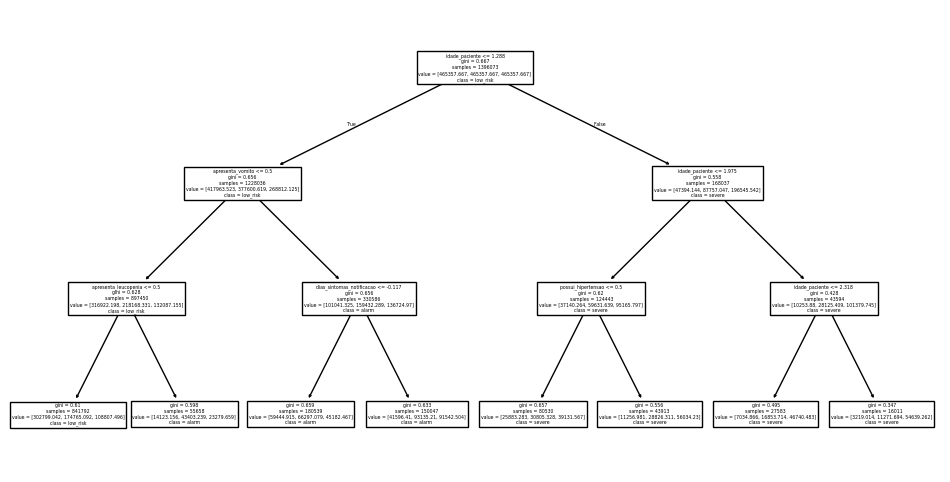

In [10]:
from sklearn.tree import plot_tree

# NOTE: Execute também sem class_weight='balanced' para comparar os resultados
dt = DecisionTreeClassifier(max_depth=3, class_weight='balanced', random_state=random_state)
dt.fit(X, y)

plt.figure(figsize=(12,6))
_ = plot_tree(dt, feature_names=feature_names, class_names=target_names)

## Amostragem de Dados

### Amostragem com SMOTE

In [59]:
class_counts = Counter(y_train)

print(f"Distribuição original das classes no conjunto de treinamento: {class_counts}")

under_sampler = RandomUnderSampler(sampling_strategy={0: class_counts[1]}, random_state=random_state)
over_sampler = SMOTE(sampling_strategy={2: class_counts[1]}, random_state=random_state)

pipeline = Pipeline([
    ('under', under_sampler),
    ('over', over_sampler)
])

X_train_resampled, y_train_resampled = pipeline.fit_resample(X_train, y_train)

print(f"Distribuição das classes após amostragem no conjunto de treinamento: {Counter(y_train_resampled)}")

Distribuição original das classes no conjunto de treinamento: Counter({0: 294594, 1: 187280, 2: 19967})
Distribuição das classes após amostragem no conjunto de treinamento: Counter({0: 187280, 1: 187280, 2: 187280})


In [60]:
f1_scores_valid = []
f1_scores_train = []

best_config_index = 0
max_f1_valid = 0

for i, config in enumerate(configs_to_test):
  dt = DecisionTreeClassifier(**config)
  dt.fit(X_train_resampled, y_train_resampled)

  y_pred = dt.predict(X_valid)
  f1_valid = f1_score(y_valid, y_pred, average='macro', zero_division=0)
  f1_scores_valid.append(f1_valid)

  y_pred_train = dt.predict(X_train)
  f1_train = f1_score(y_train, y_pred_train, average='macro', zero_division=0)
  f1_scores_train.append(f1_train)

  max_depth = config["max_depth"]
  print(f"Config: max_depth={max_depth}, F1 validação: {f1_valid:.3f}, F1 treino: {f1_train:.3f}")

  if f1_valid > max_f1_valid:
    max_f1_valid = f1_valid
    best_config_index = i

best_config = configs_to_test[best_config_index]
print(f"\nMelhor configuração: {best_config}, com F1 validação: {max_f1_valid:.3f}")

Config: max_depth=5, F1 validação: 0.372, F1 treino: 0.372
Config: max_depth=8, F1 validação: 0.463, F1 treino: 0.466
Config: max_depth=10, F1 validação: 0.479, F1 treino: 0.484
Config: max_depth=15, F1 validação: 0.495, F1 treino: 0.522
Config: max_depth=20, F1 validação: 0.502, F1 treino: 0.592
Config: max_depth=30, F1 validação: 0.503, F1 treino: 0.775
Config: max_depth=50, F1 validação: 0.500, F1 treino: 0.871
Config: max_depth=None, F1 validação: 0.501, F1 treino: 0.874

Melhor configuração: {'max_depth': 30, 'criterion': 'gini', 'random_state': 42, 'class_weight': 'balanced'}, com F1 validação: 0.503


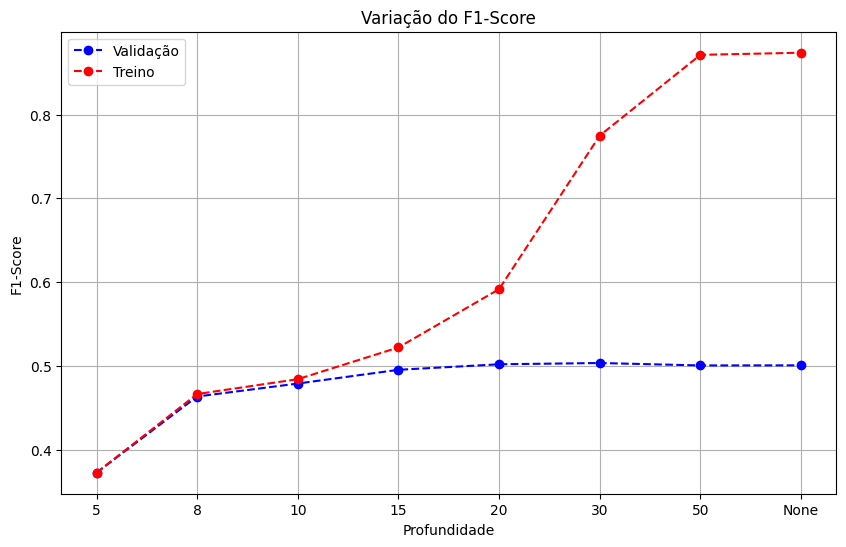

In [61]:
max_depths_as_labels = [str(cfg["max_depth"]) for cfg in configs_to_test]

plt.figure(figsize=(10,6))
plt.plot(max_depths_as_labels, f1_scores_valid, marker='o', linestyle='--', color='b', label='Validação')
plt.plot(max_depths_as_labels, f1_scores_train, marker='o', linestyle='--', color='r', label='Treino')
plt.title('Variação do F1-Score')
plt.xlabel('Profundidade')
plt.ylabel('F1-Score')
plt.legend()
plt.grid(True)
plt.show()

Para avaliarmos o desempenho do modelo otimizado em novos dados, devemos repetir o treinamento selecionando o melhor valor de hiperparâmetro(s) com base no gráfico anterior, e fazer a avaliação nos dados de teste.
Para melhorar a capacidade de estimar o desempenho do modelo, podemos treinar com os dados de treinamento e validação, tendo em vista que ambos são independentes do conjunto de teste (dados nunca vistos).


In [ ]:
X_train_full = np.concatenate((X_train, X_valid), axis=0)
y_train_full = np.concatenate((y_train, y_valid), axis=0)

class_counts = Counter(y_train_full)

under_sampler = RandomUnderSampler(sampling_strategy={0: class_counts[1]}, random_state=random_state)
over_sampler = SMOTE(sampling_strategy={2: class_counts[1]}, random_state=random_state)

pipeline = Pipeline([
    ('under', under_sampler),
    ('over', over_sampler)
])

X_train_final, y_train_final = pipeline.fit_resample(X_train_full, y_train_full)

dt = DecisionTreeClassifier(**best_config)
dt.fit(X_train_final, y_train_final)

y_pred = dt.predict(X_test)

f1_test = f1_score(y_test, y_pred, average='macro', zero_division=0)
print(f"F1-Macro (Dados de Teste): {f1_test:.3f}")

F1-Macro (Dados de Teste): 0.518


/home/gabriel/Documents/UFRGS/2025-2/ML/TF/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


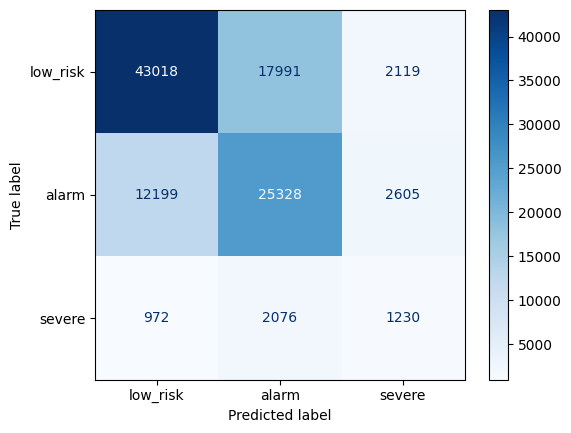

In [70]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=target_names, cmap=plt.cm.Blues)

In [60]:
report = classification_report(y_test, y_pred, target_names=target_names, zero_division=0)
print("Relatório de Classificação:\n", report)

Relatório de Classificação:
               precision    recall  f1-score   support

    low_risk       0.99      0.86      0.92     84329
       alarm       0.85      0.99      0.91     63573
      severe       0.80      0.99      0.89      6178

    accuracy                           0.92    154080
   macro avg       0.88      0.95      0.91    154080
weighted avg       0.93      0.92      0.92    154080

